In [1]:
data = r'C:\Users\akila\Learning Work\PennFudanPed'

import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image(r"C:\Users\akila\Learning Work\PennFudanPed\PNGImages\FudanPed00046.png")
mask = read_image(r"C:\Users\akila\Learning Work\PennFudanPed\PedMasks\FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

import numpy as np
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as T
import torchvision.utils as vutils
import matplotlib.pyplot as plt

from torchvision.models.detection import maskrcnn_resnet50_fpn
from engine import train_one_epoch# evaluate
import utils

In [3]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
#Object detection and instance segmentation model for PennFudan Dataset


In [ ]:
def get_transform():
    return T.Compose([
        T.ToDtype(torch.float32, scale=True),
    ])

In [ ]:
root = r"C:\Users\akila\Learning Work\PennFudanPed"  # Replace with actual path
dataset = PennFudanDataset(root, transforms=get_transform())
dataset_test = PennFudanDataset(root, transforms=get_transform())

In [ ]:
# Split dataset
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

In [ ]:
# --- Load Mask R-CNN Model ---
model = maskrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

In [ ]:
# --- Train ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
# No evaluation needed
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()


print("Training complete!")

Epoch: [0]  [ 0/60]  eta: 0:03:48  loss: 2.7959 (2.7959)  loss_classifier: 0.7376 (0.7376)  loss_box_reg: 0.3618 (0.3618)  loss_mask: 1.6601 (1.6601)  loss_objectness: 0.0334 (0.0334)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 3.8059  data: 0.0831  max mem: 1902
Epoch: [0]  [10/60]  eta: 0:01:01  loss: 0.6432 (0.9453)  loss_classifier: 0.1533 (0.2222)  loss_box_reg: 0.2508 (0.2756)  loss_mask: 0.2568 (0.4306)  loss_objectness: 0.0096 (0.0115)  loss_rpn_box_reg: 0.0052 (0.0054)  time: 1.2211  data: 0.1623  max mem: 2827
Epoch: [0]  [20/60]  eta: 0:00:42  loss: 0.5300 (0.7141)  loss_classifier: 0.0786 (0.1422)  loss_box_reg: 0.2316 (0.2472)  loss_mask: 0.1884 (0.3114)  loss_objectness: 0.0044 (0.0080)  loss_rpn_box_reg: 0.0046 (0.0054)  time: 0.9222  data: 0.1566  max mem: 2827
Epoch: [0]  [30/60]  eta: 0:00:30  loss: 0.3581 (0.6027)  loss_classifier: 0.0467 (0.1129)  loss_box_reg: 0.1251 (0.2140)  loss_mask: 0.1597 (0.2622)  loss_objectness: 0.0036 (0.0074)  loss_rpn_box_reg: 0.0046 (0.0

In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [8]:
torch.save(model.state_dict(), "maskrcnn_pennfudan.pth")


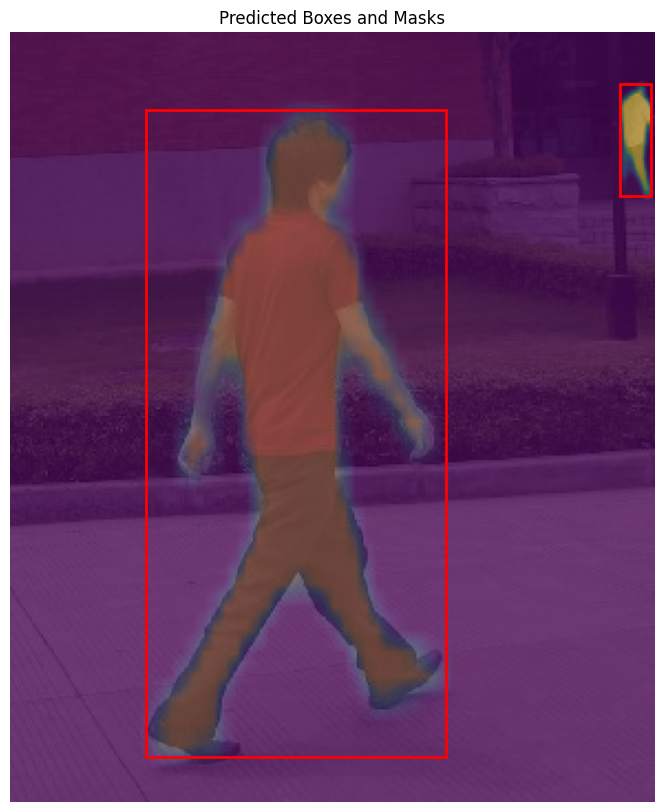

In [9]:
# Load a test image
img, _ = dataset_test[0]  # First test sample
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

# Convert image to NumPy for plotting
img_np = TF.to_pil_image(img)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(img_np)

# Draw predicted masks and boxes
pred = prediction[0]
for box, mask, score in zip(pred["boxes"], pred["masks"], pred["scores"]):
    if score > 0.5:  # Confidence threshold
        box = box.to("cpu").numpy().astype(np.int32)
        mask = mask.squeeze().to("cpu").numpy()

        # Draw box
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                          edgecolor="red", linewidth=2, fill=False))
        # Apply mask
        plt.imshow(mask, alpha=0.5)

plt.axis("off")
plt.title("Predicted Boxes and Masks")
plt.show()


 Step 3: (Optional) Use it in a Custom App
Once you're happy with results, you can:

🖼️ Use it in a real-time webcam or image processing app

🗂️ Run it on a batch of your own pedestrian images

🧠 Fine-tune it on your own dataset (if different from Penn-Fudan)



In [10]:
model.load_state_dict(torch.load("maskrcnn_pennfudan.pth"))
model.eval()


C:\Users\akila\AppData\Local\Temp\ipykernel_7796\2638844123.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("maskrcnn_pennfudan.pth"))


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in